In [1]:
from encoder import *
from decoder import *
from dataset import *
import gin

In [2]:
gin.parse_config_file("config/encoder_config1.gin")
encoder_config = EncoderConfig()

gin.parse_config_file("config/decoder_config1.gin")
decoder_config = DecoderConfig()

In [3]:
encoder = Encoder(encoder_config)
decoder = Decoder(decoder_config)

In [4]:
# img, class_name = next(iter(train_dataloader))
# img.shape, class_name

# sample input 
img = torch.randn(1, 3, 128, 128)

In [5]:
encoder_op, mask, ids_restore = encoder(img)
decoder_op = decoder((encoder_op, mask, ids_restore), img)

In [6]:
decoder_op[0].shape, decoder_op[1]

(torch.Size([1, 3, 128, 128]), tensor(1.2932, grad_fn=<MseLossBackward0>))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1760387..2.1272337].


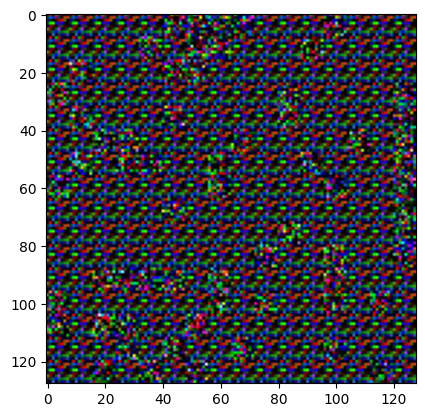

In [7]:
import matplotlib.pyplot as plt
plt.imshow(decoder_op[0].squeeze(0).detach().cpu().permute(1, 2, 0));